# 2022 Fall Business Analytics Topic 1: Dimensionality Reduction Tutorial
## Feature Selection using Genetic Algorithm
### 2022010558 김지현

# Genetic Algorithm 유전자 알고리즘

-------------

# How to Use
- 구현한 Class를 통해서 간단하게 결과를 확인할 수 있는 방법을 설명합니다.

## 0. Import Necessary Libraries

In [36]:
import argparse
import numpy as np
import rich
import argparse

# import genetic algorithm
from ga_feature_selection.genetic_algorithm import GA_FeatureSelector

from sklearn import datasets
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import MinMaxScaler

# Classification Model
from sklearn import linear_model
# from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")
sns.set_style("white")
sns.set_palette("Pastel1")

import warnings
warnings.filterwarnings(action='ignore')

## 1. Define argparser (Hyperparameter)
Genetic Algorithm에서는 여러 Hyperparameters가 있으며, 해당 값에 따라서 선택되는 설명 변수와 연산량, 그리고 성능이 달라집니다. 이때 본 튜토리얼에서는 여러 Hyperparameter를 아래 argparser를 통하여 정의해두었으며, 사용자에 따라 값을 추가하거나 자유롭게 변경할 수 있습니다.  
또한 Feature Selection 성능 및 연산량이 어떻게 달라지는 지를 직접적으로 비교하기 위해서, 본 튜토리얼에서는 아래 6가지 Hyperparameter를 바꾸어 가며 성능을 비교하였습니다.
1. 세대 당 염색체 수(n_population)
2. 적합도 함수(Fiteness Function: c-metric, r-metric)
3. 선택(Selection) 시 토너먼트 횟수 (tournament-k)
3. 교배율(crossover_rate)
5. 돌연변이율(mutation_rate)
6. 종료 조건(n_generation, if same scoring value found over 5 times than stop training)

In [2]:
GAparser = argparse.ArgumentParser()

GAparser.add_argument("--seed", default=2022, type=int)
GAparser.add_argument("--normalization", default=False, type=bool)

# Hyperparameter
GAparser.add_argument("--n-generation", default=50, type=int, help="Determines the maximum number of generations to be carry out.")
GAparser.add_argument("--n-population", default=100, type=int, help="Determines the size of the population (number of chromosomes).")
GAparser.add_argument("--crossover-rate", default=0.7, type=float, 
                      help="Defines the crossing probability. It must be a value between 0.0 and 1.0.")
GAparser.add_argument("--mutation-rate", default=0.8, type=float, 
                      help="Defines the mutation probability. It must be a value between 0.0 and 1.0.")
GAparser.add_argument("--tournament-k", default=2, type=int,
                      help="Defines the size of the tournament carried out in the selection process.\
                            Number of chromosomes facing each other in each tournament.")
GAparser.add_argument("--c-metric", default='accuracy', choices=['accuracy', 'f1_score', 'roc_auc_socre'], type=str)
GAparser.add_argument("--r-metric", default='rmse', choices=['rmse', 'corr', 'mape', 'mae'], type=str)

GAparser.add_argument("--n-jobs", default=1, choices=[1, -1], type=int, 
                      help="Number of cores to run in parallel. By default a single-core is used.")
GAparser.add_argument("--initial-best-chromosome", default=None, type=np.ndarray, 
                      help="A one-dimensional binary matrix of size equal to the number of features (M). \
                      Defines the best chromosome (subset of features) in the initial population.")
GAparser.add_argument("--verbose", default=0, type=int, help="Control the output verbosity level. It must be an integer value between 0 and 2.")

args = GAparser.parse_args(args=[])

## 2. Make Dataset
- 분류 모델을 위한 데이터셋을 불러옵니다. 본 튜토리얼에서는 Scikit-learn에서 제공하는 [Wine Quality Dataset](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009)을 활용하였습니다.
    - 178개의 관측치, 13개의 변수, 3개의 Classes
    - Trian : Test = 8 : 2 비율로 지정
- Train Test를 분리하면서는, Normalization 여부에 따라서 값 Scaling이 추가되게끔 하였습니다.

In [23]:
"""Funciton making train and test dataset"""
def make_trian_test(args:argparse, X: np.ndarray, y: np.ndarray):
    # Train and Test data split
    train_index, test_index = train_test_split(np.arange(len(X)), test_size=.2, random_state=args.seed)
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index].reshape(-1,1), y[test_index].reshape(-1,1)
    
    # Scaling both Train and Testing data (Both X and Y)
    if args.normalization:
        scaler = MinMaxScaler()
        full_train_scaled = scaler.fit_transform(np.concatenate([X_train, y_train],axis=1))
        full_test_scaled = scaler.transform(np.concatenate([X_test, y_test],axis=1))
        
        y_min = scaler.data_min_[-y_test.shape[1]:]
        y_max = scaler.data_max_[-y_test.shape[1]:]
        
        X_train , y_train, X_test, y_test = full_train_scaled[:,:-y_test.shape[1]] , full_train_scaled[:,-y_test.shape[1]:], \
                                            full_test_scaled[:,:-y_test.shape[1]] , full_test_scaled[:,-y_test.shape[1]:]
        
        return X_train, X_test, y_train, y_test, y_min, y_max
    
    else:
        return X_train, X_test, y_train, y_test

In [24]:
"""Load example toy dataset from scikit-learn"""
data = datasets.load_wine()
X, y = data['data'], data['target']

"""Split dataset into train and test"""
X_train, X_test, y_train, y_test = make_trian_test(args, X, y)

## 3. Define Classifier
- Scikit-learn에서 제공하는 지도학습 기반 머신러닝 모델을 대상으로 튜토리얼을 작성하였습니다. fit, predict, predict_proba 메소드를 제공하는 모델이어야 합니다.
    - 본 튜토리얼에서는 기본적인 분류 모델인 Logistic Regressor을 사용하였습니다.
- 해당 Classifier는 유전 알고리즘에 의해 선택된 변수가 y를 예측하는 데 얼마나 적합한지를 평가하는 적합도 함수(Fitness Function)가 될 것이며, 이때 적합도를 산출하는 기준으로는 (1) Accuracy, (2) F1-Score, (3) AUROC 세 가지 지표를 사용할 수 있습니다.

In [25]:
"""
Define Classifier: A supervised learning estimator with a fit method from Scikit-learn.
- There are lots of other options besides Logistic Regression, for example, RandomForest, Deciison Tree, XGBoost, and etc.
"""
LogisticRegression = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto')
# RandomForest = RandomForestClassifier(n_estimators=200, random_state=args.seed)
# XGBoost = XGBClassifier(n_estimators=200, random_state=args.seed)

## 4. Create Feature Selector using Genetic Algorithm
- 미리 정의된 클래스를 선언하여 학습을 준비합니다.

In [26]:
"""Create Feature Selector using Genetic Algorithm"""
Genetic_Algorithm = GA_FeatureSelector(model=LogisticRegression, args=args, seed=args.seed)

## 5. Fit train dataset and get results: test score, best features
- 본격적으로 학습을 진행시킵니다. 내장 메소드인 run으로 한 번에 학습을 수행할 수 있습니다.
- 몇 번째 세대를 학습하고 있는지, 현재까지의 최고 성능과 활용된 변수는 무엇인지 등을 학습 중에 출력하도록 합니다.

In [27]:
"""Fit features and yield test output using 'run' method"""
Genetic_Algorithm.run(X_train, X_test, y_train, y_test)

Creating initial population with 100 chromosomes 🧬

✔ Evaluating initial population...

✔ Current best chromosome: [1 0 0 0 0 1 1 0 0 1 0 1 1], Score: 0.971830985915493

Creating generation 1...

✔ Evaluating population of new generation 1...

✔ (Better) A better chromosome than the current one has been found 0.9859154929577465

✔ Current best chromosome: [1 1 1 1 0 1 1 1 1 1 0 1 0], Score: 0.9859154929577465

Elapsed generation time:  2.73 seconds

Creating generation 2...

✔ Evaluating population of new generation 2...

✔ Same scoring value found 1 / 0 times.

✔ Current best chromosome: [1 1 1 1 0 1 1 1 1 1 0 1 0], Score: 0.9859154929577465

Elapsed generation time:  2.71 seconds

Creating generation 3...

✔ Evaluating population of new generation 3...

✔ Same scoring value found 2 / 0 times.

✔ Current best chromosome: [1 1 1 1 0 1 1 1 1 1 0 1 0], Score: 0.9859154929577465

Elapsed generation time:  2.69 seconds

Creating generation 4...

✔ Evaluating population of new generation 4...

✔ (Better) A better chromosome than the current one has been found 0.9929577464788732

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.70 seconds

Creating generation 5...

✔ Evaluating population of new generation 5...

✔ (WORSE) No better chromosome than the current one has been found 0.9788732394366197

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.71 seconds

Creating generation 6...

✔ Evaluating population of new generation 6...

✔ (WORSE) No better chromosome than the current one has been found 0.9859154929577465

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.72 seconds

Creating generation 7...

✔ Evaluating population of new generation 7...

✔ (WORSE) No better chromosome than the current one has been found 0.9859154929577465

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.75 seconds

Creating generation 8...

✔ Evaluating population of new generation 8...

✔ (WORSE) No better chromosome than the current one has been found 0.971830985915493

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.73 seconds

Creating generation 9...

✔ Evaluating population of new generation 9...

✔ (WORSE) No better chromosome than the current one has been found 0.9788732394366197

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.70 seconds

Creating generation 10...

✔ Evaluating population of new generation 10...

✔ (WORSE) No better chromosome than the current one has been found 0.9788732394366197

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.73 seconds

Creating generation 11...

✔ Evaluating population of new generation 11...

✔ (WORSE) No better chromosome than the current one has been found 0.9788732394366197

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.75 seconds

Creating generation 12...

✔ Evaluating population of new generation 12...

✔ (WORSE) No better chromosome than the current one has been found 0.9859154929577465

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.76 seconds

Creating generation 13...

✔ Evaluating population of new generation 13...

✔ (WORSE) No better chromosome than the current one has been found 0.971830985915493

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.76 seconds

Creating generation 14...

✔ Evaluating population of new generation 14...

✔ (WORSE) No better chromosome than the current one has been found 0.9647887323943662

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.75 seconds

Creating generation 15...

✔ Evaluating population of new generation 15...

✔ (WORSE) No better chromosome than the current one has been found 0.9788732394366197

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.70 seconds

Creating generation 16...

✔ Evaluating population of new generation 16...

✔ (WORSE) No better chromosome than the current one has been found 0.9647887323943662

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.69 seconds

Creating generation 17...

✔ Evaluating population of new generation 17...

✔ (WORSE) No better chromosome than the current one has been found 0.9859154929577465

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.70 seconds

Creating generation 18...

✔ Evaluating population of new generation 18...

✔ (WORSE) No better chromosome than the current one has been found 0.9859154929577465

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.71 seconds

Creating generation 19...

✔ Evaluating population of new generation 19...

✔ (WORSE) No better chromosome than the current one has been found 0.971830985915493

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.70 seconds

Creating generation 20...

✔ Evaluating population of new generation 20...

✔ Same scoring value found 1 / 0 times.

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.72 seconds

Creating generation 21...

✔ Evaluating population of new generation 21...

✔ (WORSE) No better chromosome than the current one has been found 0.9788732394366197

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.74 seconds

Creating generation 22...

✔ Evaluating population of new generation 22...

✔ (WORSE) No better chromosome than the current one has been found 0.971830985915493

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.69 seconds

Creating generation 23...

✔ Evaluating population of new generation 23...

✔ (WORSE) No better chromosome than the current one has been found 0.971830985915493

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.71 seconds

Creating generation 24...

✔ Evaluating population of new generation 24...

✔ (WORSE) No better chromosome than the current one has been found 0.9859154929577465

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.73 seconds

Creating generation 25...

✔ Evaluating population of new generation 25...

✔ (WORSE) No better chromosome than the current one has been found 0.9859154929577465

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.74 seconds

Creating generation 26...

✔ Evaluating population of new generation 26...

✔ (WORSE) No better chromosome than the current one has been found 0.9859154929577465

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.68 seconds

Creating generation 27...

✔ Evaluating population of new generation 27...

✔ (WORSE) No better chromosome than the current one has been found 0.9859154929577465

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.67 seconds

Creating generation 28...

✔ Evaluating population of new generation 28...

✔ (WORSE) No better chromosome than the current one has been found 0.9859154929577465

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.72 seconds

Creating generation 29...

✔ Evaluating population of new generation 29...

✔ (WORSE) No better chromosome than the current one has been found 0.971830985915493

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.74 seconds

Creating generation 30...

✔ Evaluating population of new generation 30...

✔ Same scoring value found 1 / 0 times.

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.72 seconds

Creating generation 31...

✔ Evaluating population of new generation 31...

✔ Same scoring value found 2 / 0 times.

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.75 seconds

Creating generation 32...

✔ Evaluating population of new generation 32...

✔ (WORSE) No better chromosome than the current one has been found 0.971830985915493

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.68 seconds

Creating generation 33...

✔ Evaluating population of new generation 33...

✔ (WORSE) No better chromosome than the current one has been found 0.9859154929577465

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.73 seconds

Creating generation 34...

✔ Evaluating population of new generation 34...

✔ Same scoring value found 1 / 0 times.

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.71 seconds

Creating generation 35...

✔ Evaluating population of new generation 35...

✔ (WORSE) No better chromosome than the current one has been found 0.9788732394366197

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.70 seconds

Creating generation 36...

✔ Evaluating population of new generation 36...

✔ (WORSE) No better chromosome than the current one has been found 0.9788732394366197

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.78 seconds

Creating generation 37...

✔ Evaluating population of new generation 37...

✔ Same scoring value found 1 / 0 times.

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.73 seconds

Creating generation 38...

✔ Evaluating population of new generation 38...

✔ (WORSE) No better chromosome than the current one has been found 0.9788732394366197

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.77 seconds

Creating generation 39...

✔ Evaluating population of new generation 39...

✔ (WORSE) No better chromosome than the current one has been found 0.9788732394366197

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.72 seconds

Creating generation 40...

✔ Evaluating population of new generation 40...

✔ (WORSE) No better chromosome than the current one has been found 0.971830985915493

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.72 seconds

Creating generation 41...

✔ Evaluating population of new generation 41...

✔ (WORSE) No better chromosome than the current one has been found 0.9788732394366197

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.77 seconds

Creating generation 42...

✔ Evaluating population of new generation 42...

✔ (WORSE) No better chromosome than the current one has been found 0.9859154929577465

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.72 seconds

Creating generation 43...

✔ Evaluating population of new generation 43...

✔ Same scoring value found 1 / 0 times.

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.72 seconds

Creating generation 44...

✔ Evaluating population of new generation 44...

✔ (WORSE) No better chromosome than the current one has been found 0.9788732394366197

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.67 seconds

Creating generation 45...

✔ Evaluating population of new generation 45...

✔ (WORSE) No better chromosome than the current one has been found 0.971830985915493

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.71 seconds

Creating generation 46...

✔ Evaluating population of new generation 46...

✔ (WORSE) No better chromosome than the current one has been found 0.9788732394366197

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.67 seconds

Creating generation 47...

✔ Evaluating population of new generation 47...

✔ (WORSE) No better chromosome than the current one has been found 0.9788732394366197

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.68 seconds

Creating generation 48...

✔ Evaluating population of new generation 48...

✔ (WORSE) No better chromosome than the current one has been found 0.9788732394366197

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.69 seconds

Creating generation 49...

✔ Evaluating population of new generation 49...

✔ (WORSE) No better chromosome than the current one has been found 0.971830985915493

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.76 seconds

Creating generation 50...

✔ Evaluating population of new generation 50...

✔ (WORSE) No better chromosome than the current one has been found 0.9788732394366197

✔ Current best chromosome: [1 0 1 1 0 0 1 0 0 0 1 0 0], Score: 0.9929577464788732

Elapsed generation time:  2.71 seconds

Training time:  138.77 seconds

## 6. Show the Results
- 학습 및 검증 결과를 아래와 같이 Table 형태로 요약하여 결과를 확인합니다. 내장 메소드인 'summary table'을 이용할 수 있습니다.
    - 'table'은 학습 결과를 표로 정리하여 나타냅니다.
    - 'parameter table'은 어떤 Hyperparameter를 통해 변수를 선택하고 성능을 도출하였는지를 요약해주는 표입니다.
- 총 세대 수 50, 세대 당 염색체 수 100개, 교배율 0.7, 돌연변이율 0.8, 평가지표로 Accuracy를 활용한 결과, 13개의 변수 중 5개의 변수가 선택되었고, 절반이 되지 않는 설명변수만으로도 Test Score가 0.99가 넘는 것을 확인하였습니다.

In [28]:
"""Show the result"""
table, parameter_table = Genetic_Algorithm.summary_table()
rich.print(table)
rich.print(parameter_table)

┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃                  ┃     Selected     ┃                  ┃                 ┃                  ┃   Training Time   ┃
┃ Best Chromosome  ┃   Features ID    ┃ Best Test Score  ┃ Best Generation ┃ Best Train Score ┃       (sec)       ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ [1 0 1 1 0 0 1 0 │ [ 0  2  3  6 10] │ 0.9929577464788… │        4        │       1.0        │      138.77       │
│    0 0 1 0 0]    │                  │                  │                 │                  │                   │
└──────────────────┴──────────────────┴──────────────────┴─────────────────┴──────────────────┴───────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Number of Generation ┃ Number of Population ┃ Crossover Rate ┃ Mutation Rate ┃  Metric  ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│          50          │         100          │      0.7       │      0.8      │ accuracy │
└──────────────────────┴──────────────────────┴────────────────┴───────────────┴──────────┘

- 추가적으로 아래와 같은 방식을 통하여 최종적으로 선택된 설명변수가 무엇인지 확인할 수 있습니다.
    - Wine Dataset의 경우, 'alcohol', 'ash', 'alcalinity_of_ash', 'flavanoids', 'hue'가 중요 변수로 선택되었습니다.

In [29]:
selected_features_id = [ 0,  2,  3,  6, 10] 
data = datasets.load_wine(as_frame=True)
data['data'].columns[selected_features_id]

Index(['alcohol', 'ash', 'alcalinity_of_ash', 'flavanoids', 'hue'], dtype='object')

----------

# More Specific - Genetic Algorithm Class

Genetic Algorithm의 동작원리에 따라서, 본 알고리즘이 어떻게 동작하는지 하나하나 짚어보겠습니다.

## 0. Import Necessary Libraries

In [39]:
import numpy as np
import rich
from rich.table import Table
import argparse
import multiprocessing as mp
import numbers
import time

from sklearn.base import is_classifier
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import MinMaxScaler

from utils.metrics import return_regression_result, return_classification_result

## 1. Class 정의
- init 함수에서는 class에서 사용될 인스턴스들을 사전 정의해줍니다. 이때 c_metric, r_metirc에 대해서는 어떤 평가척도를 사용할 수 있는지 뒷 부분에서 조금 더 자세히 후술하겠습니다.
- 본 튜토리얼에서 작성된 class에서 정의된 값들 중 주요인자는 다음과 같습니다.
    - Fitness Function: model, metric
    - 세대 당 염색체 수: n_population
    - 선택(selection) 시 토너먼트 수: tournament_k
    - 교배율: crossover_rate
    - 돌연변이율: mutation_rate
    - 종료 조건: n_generation

In [ ]:
class GA_FeatureSelector():
    def __init__(self, model, args: argparse, seed):
        self.args = args  # argsparse 정의
        self.seed = seed  # seed 정의
        
        # A supervised learning estimator with a 'fit' method from scikit-learn
        self.model = model
        
        # Scaling - Normalization
        self.normalization = args.normalization
        
        # Evaluation Metirc
        if is_classifier(self.model):
            self.criterion = args.c_metric
        else:
            self.criterion = args.r_metric
            
        # Number of generations
        if args.n_generation > 0:
            self.n_generation = args.n_generation
        else:
            raise ValueError('The number of generations must be greater than 1')
            
        # Size of population (number of chromosomes)
        self.n_population = args.n_population
        
        # Crossover and mutations likelihood
        if args.crossover_rate <= 0.0 or args.mutation_rate <= 0.0 or args.crossover_rate > 1.0 or args.mutation_rate > 1.0:
            raise ValueError('Mutation and crossover rate must be a value in the range (0.0, 1.0]')
        else:
            self.crossover_rate = args.crossover_rate
            self.mutation_rate = args.mutation_rate
        
        # Tournament size in selection process
        self.tournament_k = args.tournament_k
        
        # Number of threads
        if args.n_jobs < 0 and args.n_jobs == -1:
            self.n_jobs = mp.cpu_count()
        elif args.n_jobs > 0 and args.n_jobs <= mp.cpu_count():
            self.n_jobs = args.n_jobs
        else:
            raise ValueError(
                f'n_jobs == {args.n_jobs} is invalid! You have a maximum of'
                f' {mp.cpu_count()} cores.')
            
        # for randomizing initial population   
        self.initial_best_chromosome = args.initial_best_chromosome
        
        # set random seed
        if isinstance(self.seed, numbers.Integral):
            np.random.seed(self.seed)
            
        # Verbose
        if args.verbose < 0:
            self.verbose = 0
        else:
            self.verbose = args.verbose
        
        # Best chromosome (np.ndarray, float, int) : (chromosome, score, generation index)
        self.best_chromosome = (None, None, None)
        
        # Population convergence variables
        self.convergence = False
        self.n_times_convergence = 0
        self.threshold = 1e-6

## 2. Run Genetic Algorithm
- init 함수로 인스턴스를 정의한 이후에는 Genetic Algorithm의 동작원리에 따라서 변수 선택을 시행합니다. 본 튜토리얼에서는 Genetic Algorithm의 동작을 5단계로 구분하였으며, 이를 단계적으로 살펴보면 아래와 같습니다.
- 먼저 Genetic Algorithm이 본격적으로 동작하는 구간인 run 함수를 정의하고, 이때 성능을 평가할 척도(model)와 Train set, Test set을 인자로 받습니다.

In [ ]:
class GA_FeatureSelector():
    def __init__(self, model, args: argparse, seed):
        pass
    
    def run(self, X_train, X_test, y_train, y_test):
        # Initialize output variables
        self.train_scores = []
        self.val_scores = []
        self.chromosomes_history = []
        
        # Time when training begins
        training_start = time.time()
        
        # Data
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

### 2-1. Step 1: Initialization (세대 초기화)
- Genetic Algorithm의 첫 단계는 d차원의 변수 속성 벡터를 이진수로 초기화 하는 것입니다.
    - 즉, $x_0=0$이면 0번째 변수는 사용하지 않고, $x_1=1$이라면 1번째 변수는 사용하는 방식입니다.
    - cf. 변수 선택에서 사용되는 Genetic Algorithm은 Binary Encoding을 수행하지만, 최적화 문제 등 다양한 문제에서는 Encoding scheme이 달라질 수 있습니다.
- 세대 당 염색체(Chromosome)의 수는 Hyperparameter이며, 본 튜토리얼에서는 n_population으로 수를 바꿀 수 있습니다.
- 첫 세대의 염색체의 랜덤하게 구성하며, 따라서 각 유전자마다 난수를 생성하여 세대를 구성합니다.
<br/>
- 이때 run 함수 내에 initialization이 정의된 부분은 아래와 같습니다.

In [ ]:
        # Initialize population
        rich.print(f'[bold magenta]Creating initial population with {self.n_population} chromosomes', ":dna:")
        
        ## Create n_population chromosomes
        self.population = np.random.randint(2, size=(self.n_population, self.X_train.shape[1]))

- 첫 세대의 예시를 출력해보겠습니다. 세대 내 염색체 수(n_population)는 100개이며, 세대 중 10개의 예시는 다음과 같습니다.

In [34]:
# Initialize population
rich.print(f'[bold magenta]Creating initial population with {args.n_population} chromosomes', ":dna:")

# Create n_population chromosomes
initial_population = np.random.randint(2, size=(args.n_population, X_train.shape[1]))
rich.print(f'[black][bold]Initial Population [0:10]:[/bold] \n {initial_population[0:10]}')

Creating initial population with 100 chromosomes 🧬

Initial Population [0:10]: 
 [[0 1 1 0 0 1 1 1 0 1 1 0 0]
 [0 0 0 1 0 0 0 0 1 0 1 0 0]
 [0 1 1 0 0 1 0 0 0 0 0 0 1]
 [1 0 0 1 1 1 1 1 0 0 0 0 0]
 [1 0 0 0 0 0 1 1 1 0 0 0 1]
 [0 1 0 0 0 1 0 1 1 0 1 1 1]
 [1 1 1 1 0 1 0 0 0 0 0 0 0]
 [1 0 1 1 1 0 0 1 0 0 0 0 1]
 [1 1 1 1 1 0 0 0 1 1 1 0 1]
 [0 0 0 1 1 0 1 1 0 1 0 0 0]]

### 2-2. Step 2: Model Training and Fitness Evaluation (모델 학습 및 적합도 평가)
- 위처럼 총 100개의 염색체(Chromosome)에 대해서 모델을 학습하고 적합도를 평가합니다.
- 적합도 평가는 각 염색체(Chromosome)의 정보를 사용하여 학습된 모형의 적합도를 평가하는데, 염색체의 우열을 가릴 수 있는 정략적 지표를 통해서 높은 값을 가질 수록 우수한 염색체(변수 조합)으로서 채택합니다.
    - 적합도 함수(Fitness Function)가 가져야 하는 두 가지 조건은 다음과 같습니다.
        1. 두 염색체가 __동일한 예측 성능__ 을 나타낼 경우, __적은 수의 변수__ 를 사용한 염색체 선호
        2. 두 염색체가 __동일한 변수__ 를 사용했을 경우, __우수한 예측 성능__ 을 나타내는 염색체 선호
- 본 튜토리얼에서 Classification을 위해 사용한 모델은 Logistic Regression이며, 적합도 평가를 위해 사용한 척도는 아래에 보다 자세히 서술되어 있습니다.

#### 2-2-1. Define Fitness Function
- 본 튜토리얼에서는 Classification 문제에 대한 변수 선택 적합도를 판별할 수 있는 척도로 __(1) Accuracy, (2) F1-Score, (3) AUROC Score__ 3가지를 사용하였습니다.
    1. __Accuracy (정분류율)__: 범용적으로 사용되는 분류 평가 지표이며, 전체 객체들 중 범주와 무관하게 정확하게 예측된 비율을 의미합니다.
    2. __F1-Score (F1-지표)__: 재현율(Recall)과 정밀도의 조화 평균으로 구할 수 있습니다.
        - $F1-Score = \frac{2\times Recall\times Precision}{Recall+Precision}$
        - cf. Recall (재현율): 실제 Positive Class 객체들 중 모델에 의해 Positive Class로 정확히 예측된 비율
        - cf. Precision (정밀도): 모델이 Positive Class로 예측한 객체들 중에서 실제 Positive Class인 비율
    3. __AUROC (Area Under Receiver Operating Characteristic Curve)__: 분류 기준 값(cut-off)에 따른 정오행렬의 변화를 반영하여, 가능한 모든 Cut-off 경우에 대해 True Positive Rate과 False Positive Rate을 계산합니다. 따라서 Cut-off에 독립적인 알고리즘 성능 평가 지표로서 사용될 수 있으며, 이상적인 분류기는 1의 값을 가집니다.
    
<br/>

- 아래 Fitness Evaluation Metric은 utils/metrics.py에서 보다 자세히 확인할 수 있습니다.

In [46]:
from easydict import EasyDict as edict
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

def return_classification_result(y_true, y_pred, y_proba):
    performance = edict()
    performance.accuracy = accuracy_score(y_true, y_pred)
    performance.f1_score = f1_score(y_true, y_pred, average='macro')
    performance.roc_auc_score = roc_auc_score(y_true, y_proba, multi_class='ovr')
    return performance

#### 3-2-2. Fitness Evaluation
- 위 적합도 함수(Fitness Function)를 바탕으로 생성된 염색체(변수 조합)의 적합성을 구해주는 함수는 아래와 같습니다. 함수 'evaluate fitness'는 Class 내부에 정의된 메소드이며, 동작 구조는 다음과 같습니다.
    - 염색체(Chromosome) 내의 변수 사용 여부(0, 1)를 bool type으로 바꾸어 해당 변수만을 추출한 dataset을 만들어줍니다.
    - 이후 dataset을 바탕으로 정의한 model에 fit해주고, prediction 값을 바탕으로 fitness score를 도출합니다.
    - Genetic Algorithm에서 fitness score는 높을 수록 좋으며, 본 튜토리얼에서는 Classification뿐 아니라 Rgression Task에 대한 Case도 함께 고려하여 작성되었습니다. 따라서 __Regression의 경우 Evalation metric (1) 스피어만 상관계수, (2) MAPE, (2) RMSE, (4) MAE를 1에서 빼준 값__으로 사용합니다.

In [30]:
def evaluate_fitness(self, chromosome):
    # Select those features with ones in chromosome
    x = [x.astype(bool) for x in chromosome]
    X_train_ = self.X_train[:, x]
    X_test_ = self.X_test[:, x]

    # fit
    self.model.fit(X_train_, self.y_train.ravel())

    if self.normalization:  # Undo the testing-data scaling of Y(target) according to fitted training-data scaling about Y(target)
        y_train_pred = self.model.predict(X_train_) * (self.y_max-self.y_min) + self.y_min
        y_test_pred = self.model.predict(X_test_) * (self.y_max-self.y_min) + self.y_min

    else:
        y_train_pred = self.model.predict(X_train_)
        y_test_pred = self.model.predict(X_test_)


    if is_classifier(self.model):
        y_train_proba = self.model.predict_proba(X_train_)
        y_test_proba = self.model.predict_proba(X_test_)
        train_result = return_classification_result(self.y_train, y_train_pred, y_train_proba)
        test_result = return_classification_result(self.y_test, y_test_pred, y_test_proba)
        return (train_result[self.criterion], test_result[self.criterion])

    else:
        train_result = return_regression_result(self.y_train, y_train_pred)
        test_result = return_regression_result(self.y_test, y_test_pred)
        return (train_result[self.criterion], test_result[self.criterion])

- 적합도를 계산하는 과정을 아래와 같이 예시를 통해 구해보겠습니다.

In [66]:
rich.print(':heavy_check_mark:', 'Evaluating initial population...')

# 선택된 변수만을 고려한 데이터셋 구성
x = [x.astype(bool) for x in initial_population[1]]
X_train_ = X_train[:, x]
X_test_ = X_test[:, x]

# 모델 학습
LogisticRegression.fit(X_train_, y_train.ravel())

# 학습된 결과 값 도출
if args.normalization:  # Undo the testing-data scaling of Y(target) according to fitted training-data scaling about Y(target)
    y_train_pred = LogisticRegression.predict(X_train_) * (y_max-y_min) + y_min
    y_test_pred = LogisticRegression.predict(X_test_) * (y_max-y_min) + y_min
else:
    y_train_pred = LogisticRegression.predict(X_train_)
    y_test_pred = LogisticRegression.predict(X_test_)

# 모델 학습 결과에 대한 Fitness Score 도출
if is_classifier(LogisticRegression):
    y_train_proba = LogisticRegression.predict_proba(X_train_)
    y_test_proba = LogisticRegression.predict_proba(X_test_)
    train_result = return_classification_result(y_train, y_train_pred, y_train_proba)
    test_result = return_classification_result(y_test, y_test_pred, y_test_proba)

# Show Fitness Score
rich.print('[bold] Train Results: ', train_result, '\n','[bold] Test Results:', test_result)

✔ Evaluating initial population...

 Train Results: 
{'accuracy': 0.7464788732394366, 'f1_score': 0.7603062119191151, 'roc_auc_score': 0.8986721790650222}

  Test Results:
{'accuracy': 0.6944444444444444, 'f1_score': 0.697940947940948, 'roc_auc_score': 0.8825108225108225}

- 위와 같은 과정을 거쳐 클래스 내부에서 초기 세대 염색체의 적합도를 계산하는 구간은 아래와 같습니다.
    - 학습 시에는 3가지 지표를 모두 사용하지 않고, 사용자에 따라 하나의 Metric을 골라서 자유롭게 바꾸어 쓸 수 있습니다.
    - 혹은 유전자 알고리즘의 Fitness Score가 높을 수록 좋다는 것에 기반하여, 3 지표의 평균 값으로 최종 적합도를 계산할 수도 있습니다.

In [ ]:
        # Insert initial best chromosome if is defined
        if self.initial_best_chromosome is None:
            
            # Evaluate initial population and update best_chromosome
            rich.print(' :heavy_check_mark:', 'Evaluating initial population...')
            pool = mp.Pool(self.n_jobs)
            population_scores = np.array(pool.map(self.evaluate_fitness, self.population))
            best_chromosome_index = np.argmax(population_scores[:, 0])
            
        elif type(self.initial_best_chromosome) == np.ndarray and len(self.initial_best_chromosome) == self.X_train.shape[1] and len(np.where((self.initial_best_chromosome <= 1) & (self.initial_best_chromosome >= 0))[0]):
            # Introduce the best in the population
            index_insertion = np.random.randint(self.n_population)
            self.population[index_insertion] = self.initial_best_chromosome
            
            # Evaluate initial population and update best_chromosome
            print(' :heavy_check_mark:', 'Evaluating initial population...')
            pool = mp.Pool(self.n_jobs)
            population_scores = np.array(pool.map(self.evaluate_fitness, self.population))
            best_chromosome_index = index_insertion
            
        else:
            raise ValueError('Initial best chromosome must be a 1 '
                             'dimensional binary array with a length of '
                             'X.shape[1]')

### 2-3. Step 3: Selection
- Step 2에서 적합도 함수를 통해서 부모 염색체의 우수성을 평가하였다면, Step 3에서는 우수한 부모 염색체를 선택하여 자손에게 물려줍니다. 이는 부모 염색체가 우월하다면, 자손들도 우월할 것이라는 가정에 기반합니다. 이때 부모 염색체를 선택하는 방법은 여러 가지이고, 대표적인 방법론들은 아래와 같습니다.
    1. __Deterministic Selection__  
    - 적합도 평가 결과로 산출된 rank 기준으로 상위 N%의 염색체를 선택하는 것입니다. 우수한 유전자를 물려주어 좋은 해를 만들어내기 위한 방법론입니다. 그러나 상위 N%보다 아래의 염색체 중 적합도에 차이가 얼마 나지 않는 경우를 반영하지 못한다는 한계가 존재합니다. 이를 보완한 방법이 Probabilistic Selection입니다.
    2. __Probabilistic Selection__
    - 각 염색체에 가중치를 부여하여, 모든 염색체에게 자손에게 전달해 줄 수 있는 기회를 부여하는 방법론입니다. 룰렛 휠 방식(Roulette Wheel Selection)이라고도 하며, Classification Task에서는 Softmax 확률 값에 기반하여 가중치를 부여할 수 있습니다.
    3. __Tournament Selection__
    - 무작위로 K개의 염색체를 선택하고, 이들 중 가장 우수한 염색체를 택하여 다음 세대로 전달하는 방법론입니다. 동일한 프로세스가 다음 상위 염색체를 선택하기 위해 반복되며, Deterministic Selection의 단점을 어느정도 보완한 동시에 연산 시간이 비교적 짧다는 장점을 가집니다.
    
</br>
    
- 본 튜토리얼에서는 염색체 세대가 언제나 동일해야 한다는 점에 기반하여, __Tournament Selection을 이용하여 선택을 진행__하였습니다.  가장 적합도가 높은 염색체를 선정한 이후에, 무작위로 K개의 염색체를 골라 적합도 Score를 비교하고, 높은 염색체를 고르는 과정을 세대 수만큼 반복하여 다음 세대를 만드는 것입니다. 해당 방법론의 개요를 도식화 하면 아래와 같습니다.
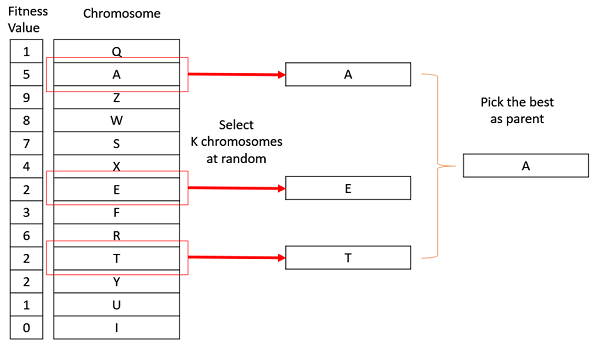
<br/>
$$[Tournament Selection]$$

- 본 튜토리얼에서 Class 내부에 정의된 Tournament Selection 함수는 아래와 같습니다.
    - Tournament 시 k의 개수는 Hyperparameter이며, argparse(tournament_k)를 통해서 사용자가 직접 바꿀 수 있습니다.

In [67]:
def selection(self, population, population_scores, best_chromosome_index):
    # Create new population
    new_population = [population[best_chromosome_index]]

    # Tournament_k chromosome tournament until fill the numpy array
    while len(new_population) != self.n_population:
        
        # Generate tournament_k positions randomly
        k_chromosomes = np.random.randint(len(population), size = self.tournament_k)
        
        # Get the best onr of these tournament_k chromosomes
        best_of_tournament_index = np.argmax(population_scores[k_chromosomes])
        
        # Append it to the new population
        new_population.append(population[k_chromosomes[best_of_tournament_index]])

    return np.array(new_population)

- 예시를 통해 Tournament Selection의 결과를 보겠습니다. K는 2로 설정하였으며, 임의로 10개의 염색체에 대해서 산출된 Fitness Score를 기반으로 다음 세대를 만들어낸 결과입니다.

In [140]:
population = initial_population[0:10]
                            #   Train Score, Test Score
population_scores = np.array([ [0.85211268,  0.72222222],
                               [0.87323944,  0.83333333],
                               [0.91549296,  0.80555556],
                               [0.8028169 ,  0.86111111],
                               [0.97183099,  0.86111111],
                               [0.88732394,  0.94444444],
                               [0.94366197,  0.88888889],
                               [0.95774648,  0.94444444],
                               [0.88732394,  0.91666667],
                               [0.85211268,  0.72222222]])
best_chromosome_index = np.argmax(population_scores[:, 0])

new_population = [population[best_chromosome_index]]
while len(new_population) != args.n_population:
    k_chromosomes = np.random.randint(len(population), size = args.tournament_k)
    best_of_tournament_index = np.argmax(population_scores[k_chromosomes])
    new_population.append(population[best_of_tournament_index])
    
rich.print('[green][bold]new population: ', '\n', f'[black]{np.array(new_population[0:10])}')
rich.print('[magenta][bold]previous population', '\n', f'[black]{population}')

new population:  
 [[1 0 0 0 0 0 1 1 1 0 0 0 1]
 [0 0 0 1 0 0 0 0 1 0 1 0 0]
 [0 1 1 0 0 1 1 1 0 1 1 0 0]
 [0 1 1 0 0 1 0 0 0 0 0 0 1]
 [0 1 1 0 0 1 1 1 0 1 1 0 0]
 [0 1 1 0 0 1 0 0 0 0 0 0 1]
 [1 0 0 1 1 1 1 1 0 0 0 0 0]
 [1 0 0 1 1 1 1 1 0 0 0 0 0]
 [0 1 1 0 0 1 1 1 0 1 1 0 0]
 [0 1 1 0 0 1 0 0 0 0 0 0 1]]

previous population 
 [[0 1 1 0 0 1 1 1 0 1 1 0 0]
 [0 0 0 1 0 0 0 0 1 0 1 0 0]
 [0 1 1 0 0 1 0 0 0 0 0 0 1]
 [1 0 0 1 1 1 1 1 0 0 0 0 0]
 [1 0 0 0 0 0 1 1 1 0 0 0 1]
 [0 1 0 0 0 1 0 1 1 0 1 1 1]
 [1 1 1 1 0 1 0 0 0 0 0 0 0]
 [1 0 1 1 1 0 0 1 0 0 0 0 1]
 [1 1 1 1 1 0 0 0 1 1 1 0 1]
 [0 0 0 1 1 0 1 1 0 1 0 0 0]]

### 2-4. Step 4: Crossover & Mutation
#### Crossover 교배
- 선택된 부모 염색체로부터 자식세대를 재생산해내는 과정입니다. 
- 앞 단계에서 선택된 부모 염색체들의 유전자 정보를 서로 교환하여 새로운 자식 염색체들을 최종적으로 생성해냅니다.
- 본 튜토리얼에서는 교배율을 Hyperparameter로 지정하여, 얼마나 많은 변수들을 교환하여 자식 염색체를 생성해낼 지를 자유롭게 지정할 수 있게 하였습니다.
- 본 튜토리얼에서 사용된 교배율(crossover_rate)은 0.7입니다.

#### Mutation 돌연변이
- 돌연변이는 세대가 진화해 가는 과정에서 다양성을 확보하기 위한 장치입니다.
- 특정 유전자의 정보를 낮은 확률로 반대 값으로 변환하는 과정을 통해 돌연변이를 유도합니다.
- 돌연변이를 통해 현재 해가 Local Optimum에서 탈출할 수 있는 기회를 제공하지만, 너무 높은 돌연변이율은 유전 알고리즘의 convergence 속도를 늦추기에 주로 0.01 이하의 값을 사용합니다.
- 본 튜토리얼에서는 돌연변이율을 0.8인 매우 높은 값으로 두어, 결과가 어떠한지를 해석해보고자 합니다.

- 본 튜토리얼에서는 교배를 거친 뒤 돌연변이를 발생시켜 후세대(new_population)를 구성합니다. 이때 class 내부에 정의된 crossover와 mutation 함수는 아래와 같습니다.

In [120]:
def crossover(self, population):
    # Define the number of crosses
    n_crosses = int(self.crossover_rate * int(self.n_population / 2))

    # Make a copy from current population
    crossover_population = population.copy()

    # Make n_crosses crosses
    for i in range(0, n_crosses*2, 2):
        cut_index = np.random.randint(1, self.X_train.shape[1])
        tmp = crossover_population[i, cut_index:].copy()
        crossover_population[i, cut_index:], crossover_population[i+1, cut_index:] = crossover_population[i+1, cut_index:], tmp
        # Avoid null chromosomes
        if not all(crossover_population[i]):
            crossover_population[i] = population[i]
        if not all(crossover_population[i+1]):
            crossover_population[i+1] = population[i+1]

    return crossover_population

In [121]:
def mutation(self, population):
    # Define number of mutations to do
    n_mutations = int(
        self.mutation_rate * self.n_population * self.X_train.shape[1])

    # Mutating n_mutations genes
    for _ in range(n_mutations):
        chromosome_index = np.random.randint(0, self.n_population)
        gene_index = np.random.randint(0, self.X_train.shape[1])
        population[chromosome_index, gene_index] = 0 if \
            population[chromosome_index, gene_index] == 1 else 1

    return population

- 예시를 통해 교배와 돌연변이를 거친 결과를 각각 보겠습니다. Step 3에서 도출된 new_generation 염색체를 대상으로 진행합니다.

__Crossover 교배__

In [133]:
new_population = np.array(new_population)

# Crossover
n_crosses = int(args.crossover_rate * int(10 / 2))  # 교배율을 바탕으로 교배시킬 유전자 개수를 지정합니다
crossover_population = new_population.copy()      

# n_crosses만큼의 유전자를 교차시킵니다
for i in range(0, n_crosses*2, 2):
    cut_index = np.random.randint(1, X_train.shape[1])  # n_crosses 만큼의 유전자를 랜덤하게 뽑아냅니다
    tmp = crossover_population[i, cut_index:].copy()
    crossover_population[i, cut_index:], crossover_population[i+1, cut_index:] = crossover_population[i+1, cut_index:], tmp
    
    # 염색체에 null 값이 있는 것을 피하기 위한 코드
    if not all(crossover_population[i]):
        crossover_population[i] = population[i]
    if not all(crossover_population[i+1]):
        crossover_population[i+1] = population[i+1]

rich.print('[green][bold]crossovered population: ', '\n', f'[black]{crossover_population[0:10]}')
rich.print('[magenta][bold]previous new population', '\n', f'[black]{new_population[0:10]}')

crossovered population:  
 [[0 1 1 0 0 1 1 1 0 1 1 0 0]
 [0 0 0 1 0 0 0 0 1 0 1 0 0]
 [0 1 1 0 0 1 0 0 0 0 0 0 1]
 [1 0 0 1 1 1 1 1 0 0 0 0 0]
 [1 0 0 0 0 0 1 1 1 0 0 0 1]
 [0 1 0 0 0 1 0 1 1 0 1 1 1]
 [0 0 0 1 0 0 0 0 1 0 1 0 0]
 [0 1 1 0 0 1 1 1 0 1 1 0 0]
 [1 0 0 1 1 1 1 1 0 0 0 0 0]
 [1 0 0 1 1 1 1 1 0 0 0 0 0]]

previous new population 
 [[1 0 0 0 0 0 1 1 1 0 0 0 1]
 [0 1 1 0 0 1 1 1 0 1 1 0 0]
 [0 1 1 0 0 1 0 0 0 0 0 0 1]
 [0 1 1 0 0 1 0 0 0 0 0 0 1]
 [0 1 1 0 0 1 1 1 0 1 1 0 0]
 [0 1 1 0 0 1 1 1 0 1 1 0 0]
 [0 0 0 1 0 0 0 0 1 0 1 0 0]
 [0 1 1 0 0 1 1 1 0 1 1 0 0]
 [1 0 0 1 1 1 1 1 0 0 0 0 0]
 [1 0 0 1 1 1 1 1 0 0 0 0 0]]

__Mutation 돌연변이__
- 돌연변이율에 따라서 결과가 얼마나 달라지는 지를 확인해보겠습니다

In [134]:
large_mutations = int(args.mutation_rate * 10 * X_train.shape[1])    # 돌연변이율이 80%일 때
small_mutations = int(0.01 * 10 * X_train.shape[1])                  # 돌연변이율이 1%일 때

In [135]:
# 돌연변이율 80%일 때의 결과

large_mu_pop = crossover_population.copy()

for _ in range(large_mutations):
    chromosome_index = np.random.randint(0, 10)
    gene_index = np.random.randint(0, X_train.shape[1])
    large_mu_pop[chromosome_index, gene_index] = 0 if \
        large_mu_pop[chromosome_index, gene_index] == 1 else 1

rich.print('[green][bold]mutated population (0.8): ', '\n', f'[black]{large_mu_pop[0:10]}')
rich.print('[magenta][bold]previous new population', '\n', f'[black]{crossover_population[0:10]}')

mutated population (0.8):  
 [[1 0 0 1 1 1 0 1 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 1 0 0 0 1]
 [1 0 0 0 1 1 0 0 0 0 1 1 1]
 [1 1 0 0 0 1 0 1 0 0 0 0 0]
 [1 1 1 0 0 0 1 0 0 1 0 1 0]
 [1 0 1 0 1 1 0 1 0 0 1 1 1]
 [0 1 0 0 1 1 1 0 1 0 0 0 0]
 [1 1 0 0 0 1 1 1 1 1 0 0 0]
 [0 0 0 1 1 0 0 0 0 1 0 0 0]
 [1 0 1 1 1 0 0 1 1 0 0 0 0]]

previous new population 
 [[0 1 1 0 0 1 1 1 0 1 1 0 0]
 [0 0 0 1 0 0 0 0 1 0 1 0 0]
 [0 1 1 0 0 1 0 0 0 0 0 0 1]
 [1 0 0 1 1 1 1 1 0 0 0 0 0]
 [1 0 0 0 0 0 1 1 1 0 0 0 1]
 [0 1 0 0 0 1 0 1 1 0 1 1 1]
 [0 0 0 1 0 0 0 0 1 0 1 0 0]
 [0 1 1 0 0 1 1 1 0 1 1 0 0]
 [1 0 0 1 1 1 1 1 0 0 0 0 0]
 [1 0 0 1 1 1 1 1 0 0 0 0 0]]

In [137]:
# 돌연변이율 80%일 때의 결과

small_mu_pop = crossover_population.copy()

for _ in range(small_mutations):
    chromosome_index = np.random.randint(0, 10)
    gene_index = np.random.randint(0, X_train.shape[1])
    small_mu_pop[chromosome_index, gene_index] = 0 if \
        small_mu_pop[chromosome_index, gene_index] == 1 else 1

rich.print('[green][bold]mutated population (0.01): ', '\n', f'[black]{small_mu_pop[0:10]}')
rich.print('[magenta][bold]previous new population', '\n', f'[black]{crossover_population[0:10]}')

mutated population (0.01):  
 [[0 1 1 0 0 1 1 1 0 1 1 0 0]
 [0 0 0 1 0 0 0 0 1 0 1 0 0]
 [0 1 1 0 0 1 0 0 0 0 0 0 1]
 [1 0 0 1 1 1 1 1 1 0 0 0 0]
 [1 0 0 0 0 0 1 1 1 0 0 0 1]
 [0 1 0 0 0 1 0 1 1 0 1 1 1]
 [0 0 0 1 0 0 0 0 1 0 1 0 0]
 [0 1 1 0 0 1 1 1 0 1 1 0 0]
 [1 0 0 1 1 1 1 1 0 0 0 0 0]
 [1 0 0 1 1 1 1 1 0 0 0 0 0]]

previous new population 
 [[0 1 1 0 0 1 1 1 0 1 1 0 0]
 [0 0 0 1 0 0 0 0 1 0 1 0 0]
 [0 1 1 0 0 1 0 0 0 0 0 0 1]
 [1 0 0 1 1 1 1 1 0 0 0 0 0]
 [1 0 0 0 0 0 1 1 1 0 0 0 1]
 [0 1 0 0 0 1 0 1 1 0 1 1 1]
 [0 0 0 1 0 0 0 0 1 0 1 0 0]
 [0 1 1 0 0 1 1 1 0 1 1 0 0]
 [1 0 0 1 1 1 1 1 0 0 0 0 0]
 [1 0 0 1 1 1 1 1 0 0 0 0 0]]

- 돌연변이율을 많이 발생시킬 수록 구성되는 최종적으로 사용되는 변수 조합이 매우 달라짐을 알 수 있습니다.
- 최적화 알고리즘에서는 Exploitation과 Exploration의 균형을 갖는 것이 중요합니다. Crossover는 Exploitation에 해당하며 Mutation은 Exploration에 해당합니다.
    - 다시 말해, 돌연변이율(mutation_rate)이 크면 클수록 현재 탐색하고 있는 공간 밖의 global optimum을 재탐색할 수 있는 기회를 제공하는 것입니다. 그러나 optimal을 찾을 때까지 시간이 오래 소요될 수 있다는 단점이 존재합니다.
    - 반면 mutation_rate을 작은 값으로 설정할 경우에는 local optimum을 찾아 convergence가 일찍 될 수 있다는 장점이 있습니다.

### 3-5. Step 5: Evaluate New Population and Update Best Chromosome
- Step 4 교배 및 돌연변이를 통해 최종 다음 세대를 구성하였다면, 이후에는 다시 세대 적합도를 검증하고 최상의 염색체(변수 조합)를 업데이트 하는 과정을 거칩니다.
- 본 튜토리얼에서는 해당  과정에서 유전 알고리즘의 Hyperparameter 중 하나인 __종료 조건(Stopping Criteria)에 대해서 정의__하였습니다.
    - 기본적인 종료 조건은 세대 수(n_generation)로, 지정된 수만큼 세대가 구성되었다면 이에 따라 알고리즘이 종료됩니다.
    - 그러나 세대가 다 구성되지 않았더라도 성능이 지정된 threshold 보다 개선되지 않는다면 알고리즘을 조기적으로 종료하도록 하였습니다.

- class 내부에서 정의된 함수는 아래와 같습니다.

In [ ]:
def update_best_chromosome(self, population, population_scores, best_chromosome_index, i_gen: int):
    # Initialize best_chromosome
    if self.best_chromosome[0] is None and self.best_chromosome[1] is None:
        self.best_chromosome = (
            population[best_chromosome_index],
            population_scores[best_chromosome_index],
            i_gen)
        self.threshold_times_convergence = 5

    # Update if new generation is better
    elif population_scores[best_chromosome_index] > self.best_chromosome[1]:
        if i_gen >= round(0.5 * self.n_generation):
            self.threshold_times_convergence = int(np.ceil(0.3 * i_gen))
        self.best_chromosome = (
            population[best_chromosome_index],
            population_scores[best_chromosome_index],
            i_gen)
        self.n_times_convergence = 0
        rich.print(' :heavy_check_mark:', f'[bold green](Better)[/bold green] A better chromosome than the current one has been found \n 
                   {self.best_chromosome[1]}')

    # If is smaller than self.threshold count it until convergence
    elif abs(population_scores[best_chromosome_index] - self.best_chromosome[1]) <= self.threshold:
        self.n_times_convergence = self.n_times_convergence + 1
        rich.print(' :heavy_check_mark:', f'[magenta]Same scoring value found {self.n_times_convergence} / \n
                    {self.threshold_times_convergence} times.')
        if self.n_times_convergence == self.threshold_times_convergence:
            self.convergence = True

    else:
        self.n_times_convergence = 0
        rich.print(' :heavy_check_mark:', f'[bold red](WORSE)[/bold red] No better chromosome than the current one has been found \n
                    {population_scores[best_chromosome_index]}')

    rich.print(" :heavy_check_mark:", f'Current best chromosome:', f'{self.best_chromosome[0]},', f'Score: {self.best_chromosome[1]}')

__종료 조건(Stopping Criteria)__
1. 초기에는 최상의 변수 조합(best_chromosome)을 (None, None, None)으로 두며, threshold_times_convergence를 5로 임의 설정합니다.
    - 이는 일찍 optimal을 찾아 모델이 초기에 조기 수렴했을 가능성을 상정하여, 만일 5번 이상 같은 Score 값을 산출한다면 학습을 종료하도록 하는 것입니다.
2. 만일 지정한 세대 수의 절반 이상 학습이 진행되었다면, threshold_times_convergence를 생성된 세대 수의 30% 만큼으로 지정하여, 해당 수 이상으로 Score 값이 일정하다면 학습을 종료합니다.
3. 새로운 자식 세대의 최고 성능과 전 세대의 최고 성능 간 차이가 지정한 threshold 보다 낮다면, threshold_times_convergence 횟수만큼 반복될 경우 학습을 조기 종료합니다.

- 위 방식에 기반하여 최종적으로 짜인 run 함수는 아래와 같습니다.

In [ ]:
def run(self, X_train, X_test, y_train, y_test):

    # Initialize output variables
    self.train_scores = []
    self.val_scores = []
    self.chromosomes_history = []

    # Time when training begins
    training_start = time.time()

    # Data
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test

    # Initialize population
    rich.print(f'[bold magenta]Creating initial population with {self.n_population} chromosomes', ":dna:")

    ## Create n_population chromosomes
    self.population = np.random.randint(2, size=(self.n_population, self.X_train.shape[1]))

    # Insert initial best chromosome if is defined
    if self.initial_best_chromosome is None:

        # Evaluate initial population and update best_chromosome
        rich.print(' :heavy_check_mark:', 'Evaluating initial population...')
        pool = mp.Pool(self.n_jobs)
        population_scores = np.array(pool.map(self.evaluate_fitness, self.population))
        best_chromosome_index = np.argmax(population_scores[:, 0])

    elif type(self.initial_best_chromosome) == np.ndarray and len(self.initial_best_chromosome) == self.X_train.shape[1] and len(np.where((self.initial_best_chromosome <= 1) & (self.initial_best_chromosome >= 0))[0]):
        # Introduce the best in the population
        index_insertion = np.random.randint(self.n_population)
        self.population[index_insertion] = self.initial_best_chromosome

        # Evaluate initial population and update best_chromosome
        print(' :heavy_check_mark:', 'Evaluating initial population...')
        pool = mp.Pool(self.n_jobs)
        population_scores = np.array(pool.map(self.evaluate_fitness, self.population))
        best_chromosome_index = index_insertion

    else:
        raise ValueError('Initial best chromosome must be a 1 '
                         'dimensional binary array with a length of '
                         'X.shape[1]')

    # Update best chromosome found
    self.update_best_chromosome(
        self.population, population_scores[:, 0],
        best_chromosome_index, i_gen=0)

    # Save result
    self.save_results(val_score=population_scores[best_chromosome_index, 0],
                      best_current_chromosome=self.population[best_chromosome_index],
                      train_score=population_scores[best_chromosome_index, 1])

    # Loop until evaluation converge
    i = 0
    while i < self.n_generation and not self.convergence:
        # Time when generation begins
        generation_start = time.time()
        rich.print(f'[bold magenta]Creating generation {i + 1}...')

        # Step 1: Selection
        new_population = self.selection(self.population, population_scores[:, 0], best_chromosome_index)
        # print(f'\n Selection {i+1} done')

        # Step 2: Crossover
        new_population = self.crossover(new_population)
        # print(f'\n Crossover {i+1} done')

        # Step 3: Mutation
        new_population = self.mutation(new_population)
        # print(f'\n Mutation {i+1} done')

        # Step 4: Replace previous population with new_population
        self.population = new_population.copy()

        # Step 5: Evaluate new population and update best_chromosome
        rich.print(' :heavy_check_mark:', f'Evaluating population of new generation {i+1}...')
        pool = mp.Pool(self.n_jobs)
        population_scores = np.array(pool.map(self.evaluate_fitness, self.population))
        best_chromosome_index = np.argmax(population_scores[:, 0])
        self.update_best_chromosome(
            self.population, population_scores[:, 0],
            best_chromosome_index, i+1)

        # Save results
        self.save_results(
            val_score=population_scores[best_chromosome_index, 0],
            best_current_chromosome=self.population
            [best_chromosome_index],
            train_score=population_scores[best_chromosome_index, 1])

        # Step 6: Next generation
        i = i+1

        # Time when generation ends
        generation_end = time.time() - generation_start
        rich.print('    [bold]Elapsed generation time: ', f'%.2f [bold]seconds' % generation_end)

    # Time when training ends
    self.training_end = time.time() - training_start
    rich.print('[bold]Training time[/bold]: ', f'%.2f [bold]seconds' % self.training_end)